# RISEI

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

RANDOM_SEED = 250398
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [4]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201214-173421
Wall time: 5.01 ms


In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
#     'dropout': 0.10,
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': False,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 50,
    'tensorboard_update_freq': 'epoch', 
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
    'augmentations': True,
    'batch_size': 10,
#     'model_checkpoint_callback': False,
}

## Model

In [6]:
model = create_model(**model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 21, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 17, 21, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 5, 4, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 10240)             0

In [7]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '20201214-154759', 'cp-0132.ckpt')

loading checkpoint from ../../tmp\bckp-checkpoints\20201214-154759\cp-0132.ckpt...


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8148148148148148
recall: 0.7096774193548387
f1-score: 0.7586206896551724
support: 62


CN
precision: 0.6086956521739131
recall: 0.7368421052631579
f1-score: 0.6666666666666666
support: 38


micro avg
precision: 0.72
recall: 0.72
f1-score: 0.72
support: 100


macro avg
precision: 0.711755233494364
recall: 0.7232597623089982
f1-score: 0.7126436781609196
support: 100


weighted avg
precision: 0.7364895330112722
recall: 0.72
f1-score: 0.7236781609195403
support: 100


samples avg
precision: 0.72
recall: 0.72
f1-score: 0.72
support: 100


F1
micro: 0.72
macro: 0.7126436781609196


accuracy_score: 0.72
sensitivity_score: 0.7096774193548387
specificity_score: 0.7368421052631579


Wall time: 25.1 s


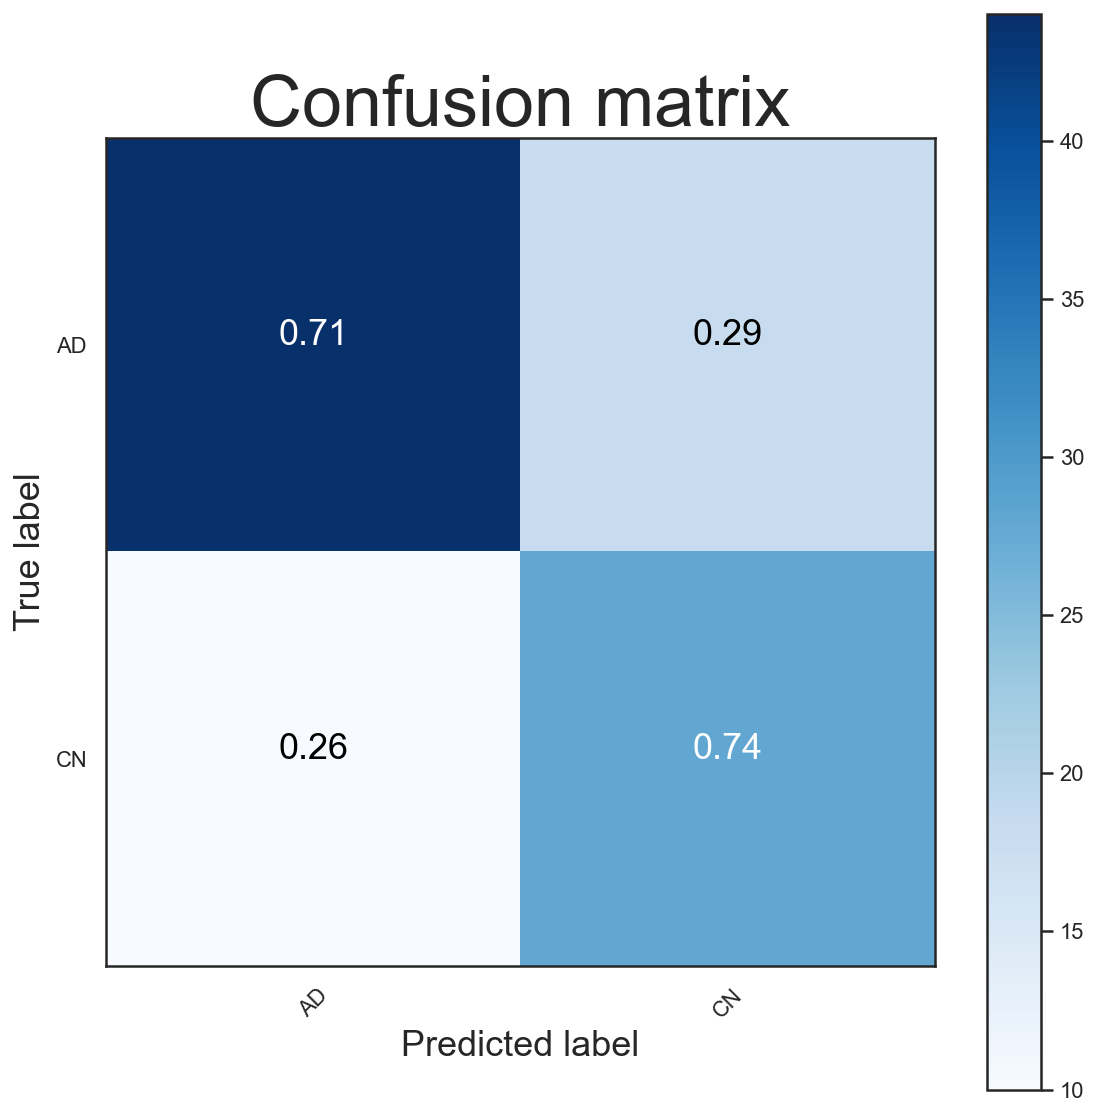

In [8]:
%%time

show_metrics(model, test_seq, class_names)

## RISEI

In [9]:
import SimpleITK as sitk

import src.heatmaps as heatmaps
import src.data.plot_image as plot_image

from src.heatmaps.evaluation import EvaluationSequence, plot_evaluation, predict_sequence_as_numpy

from src.risei import RISEI

In [10]:
idx = 4
batch_x, batch_y, *_ = train_seq[0]
image_x = batch_x[idx]
image_y = batch_y[idx]

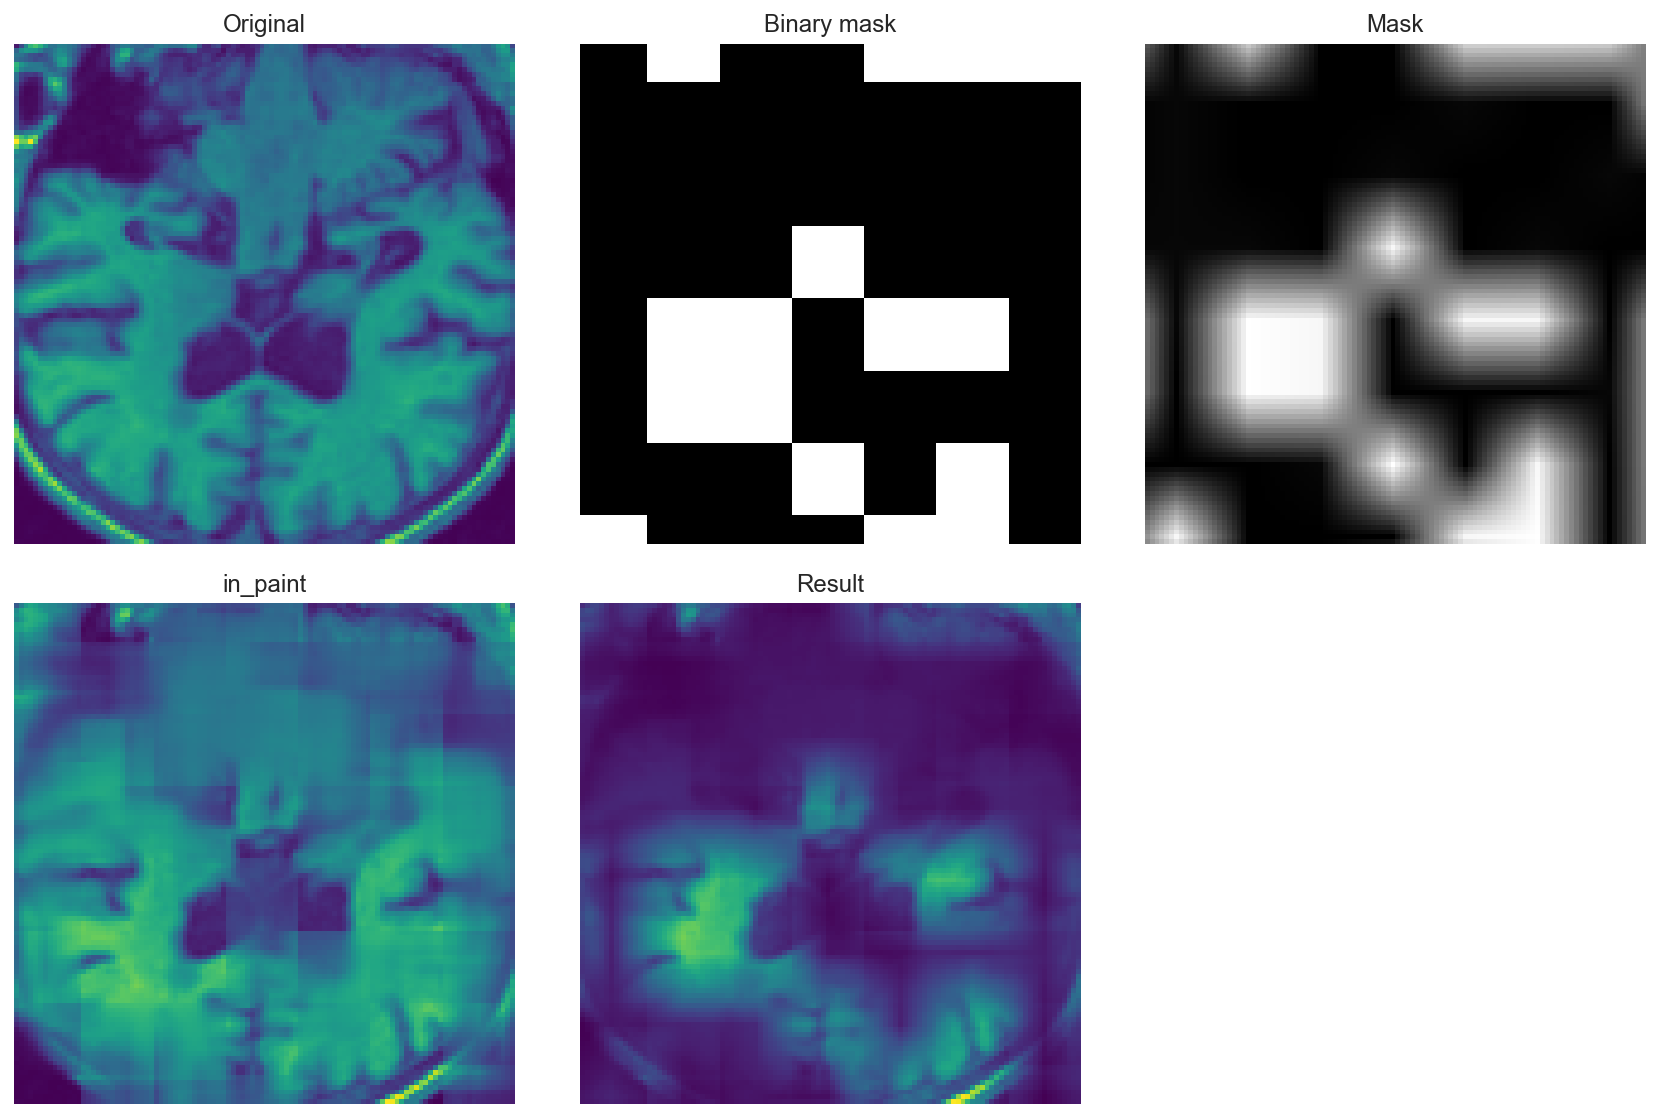

Wall time: 4.47 s


In [11]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=0.8,
    b2=0.8, 
    in_paint='2d', 
    in_paint_blending=True,
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

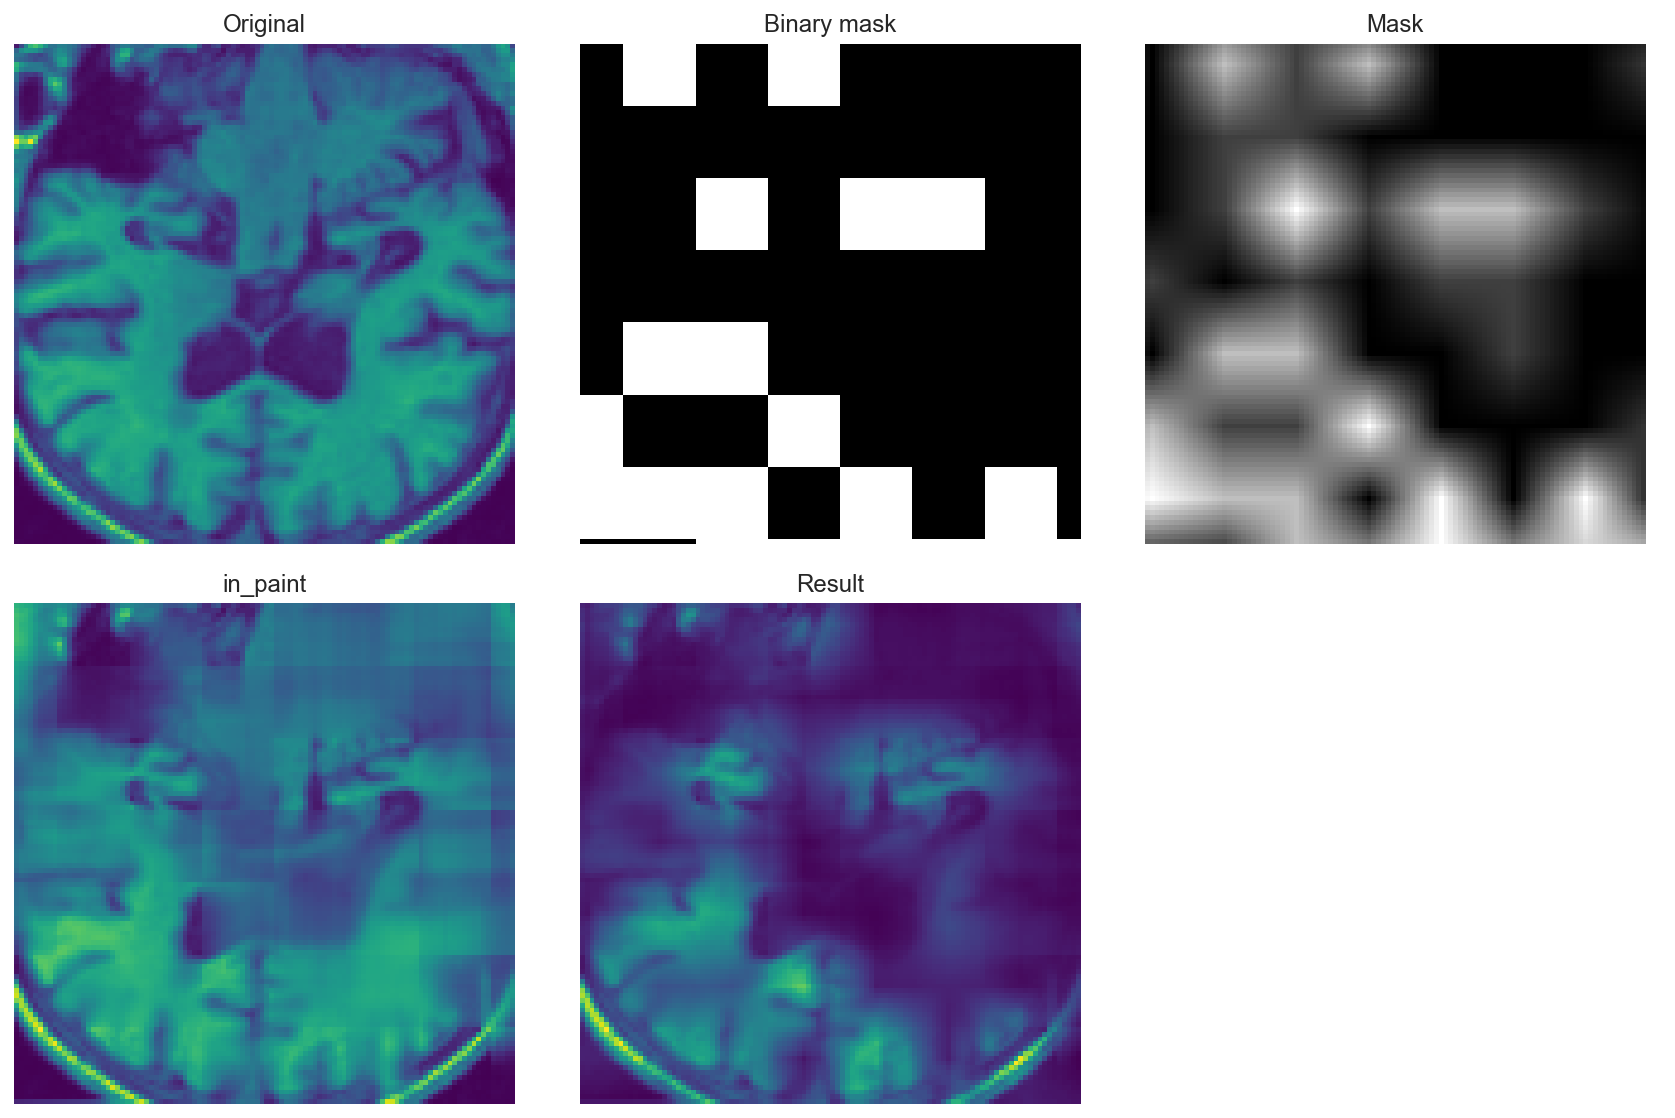

Wall time: 4.54 s


In [12]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=0.8,
    b2=0.8, 
    in_paint='2d', 
    in_paint_blending=True, 
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

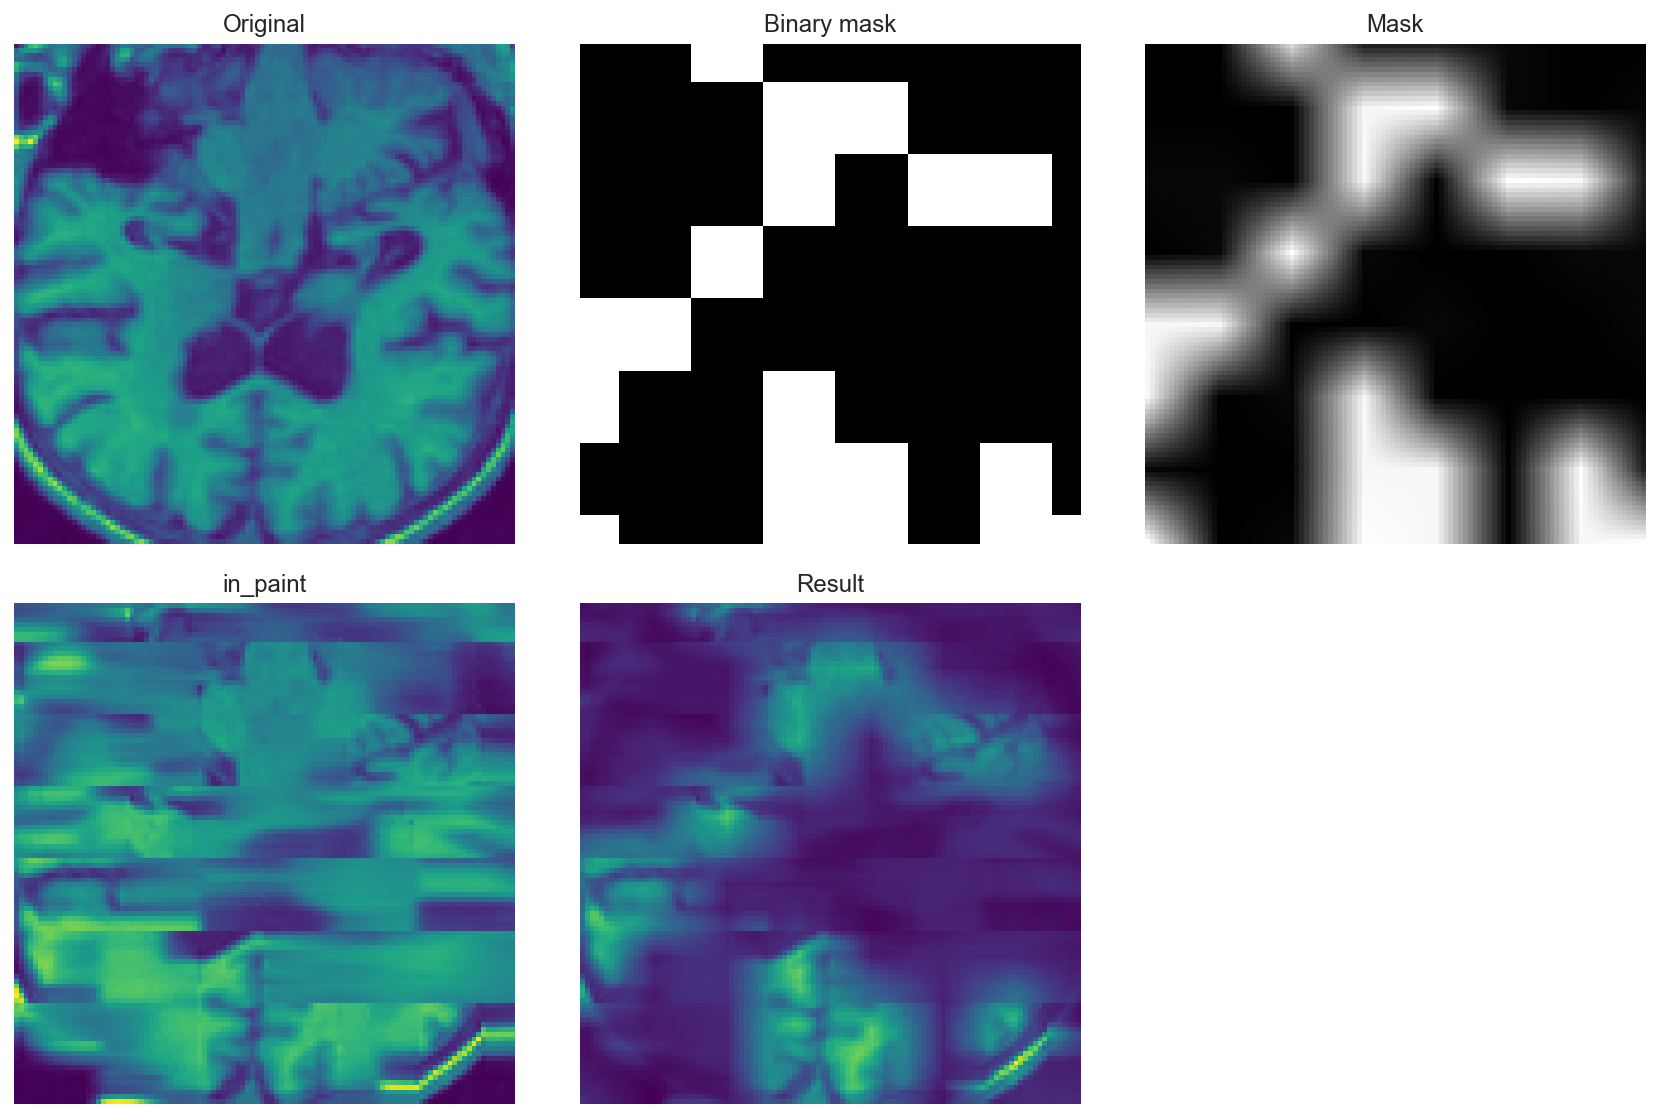

Wall time: 2.2 s


In [13]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=0.8, 
    b2=0.8, 
    in_paint='2d', 
    in_paint_blending=False, 
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

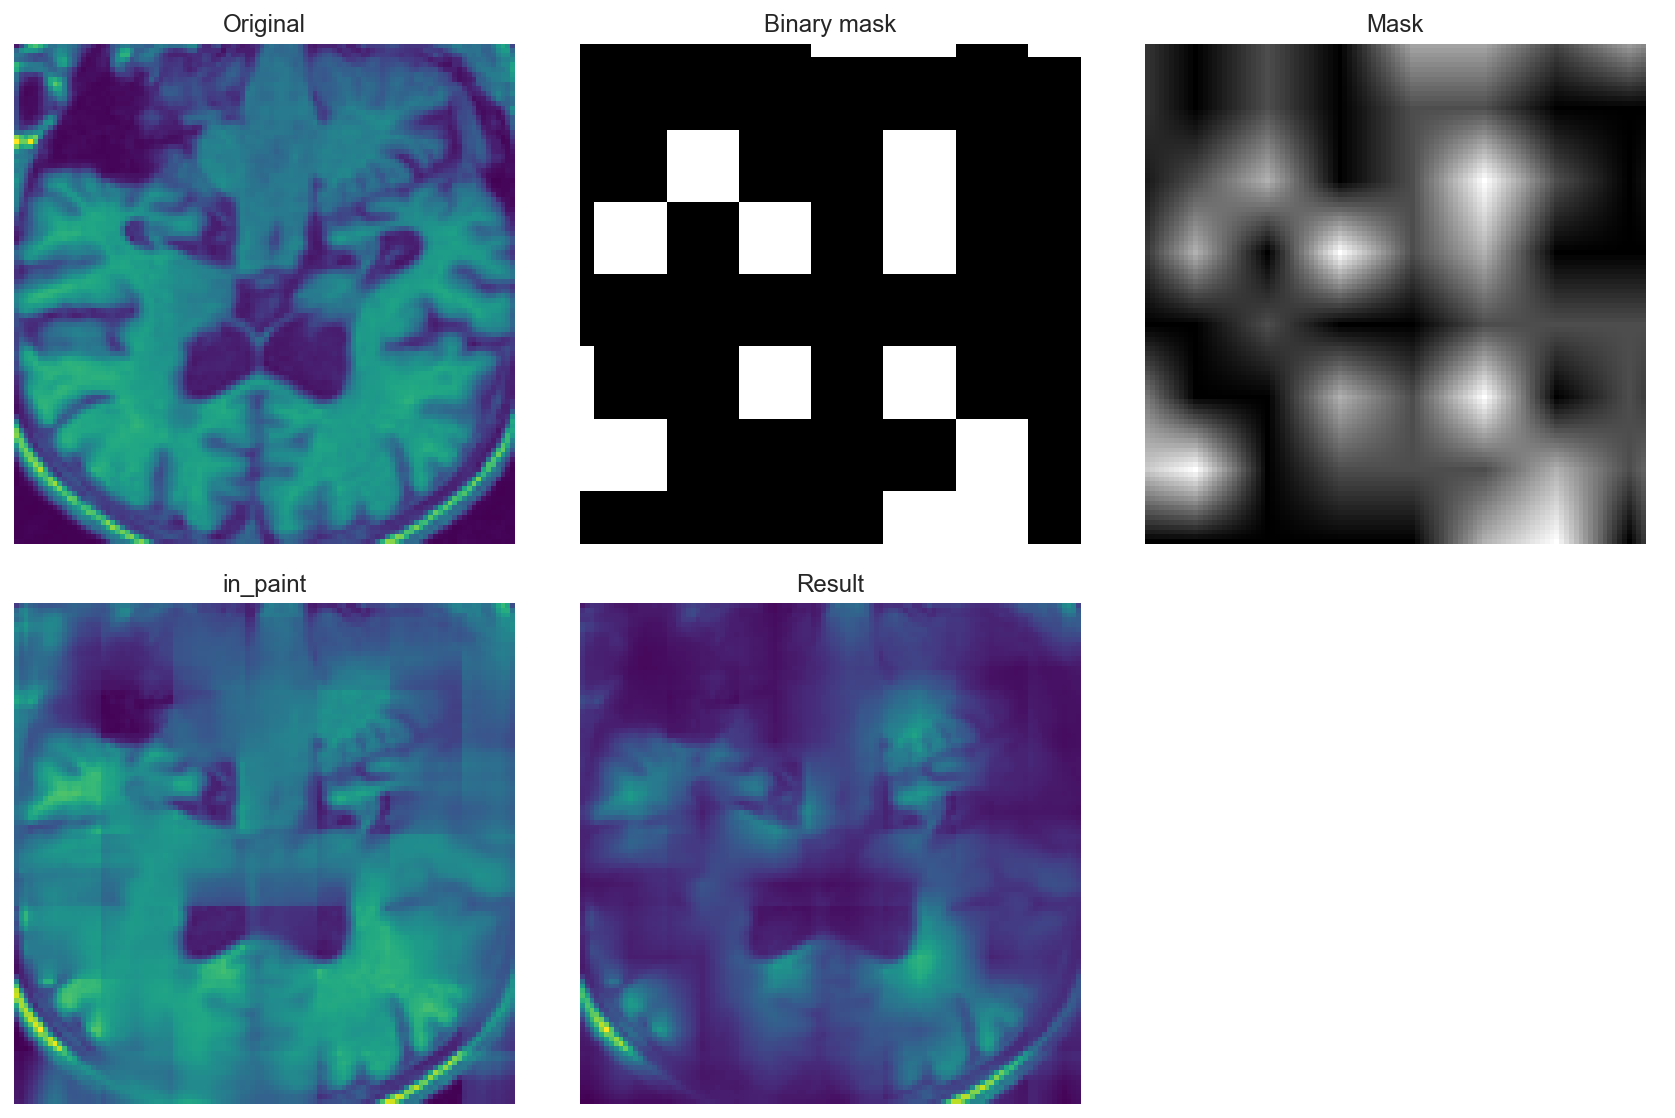

Wall time: 1min 6s


In [14]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=0.8, 
    b2=0.8, 
    in_paint='2d', 
    in_paint_blending=True, 
    in_paint_radius=25,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

Proposed settings...

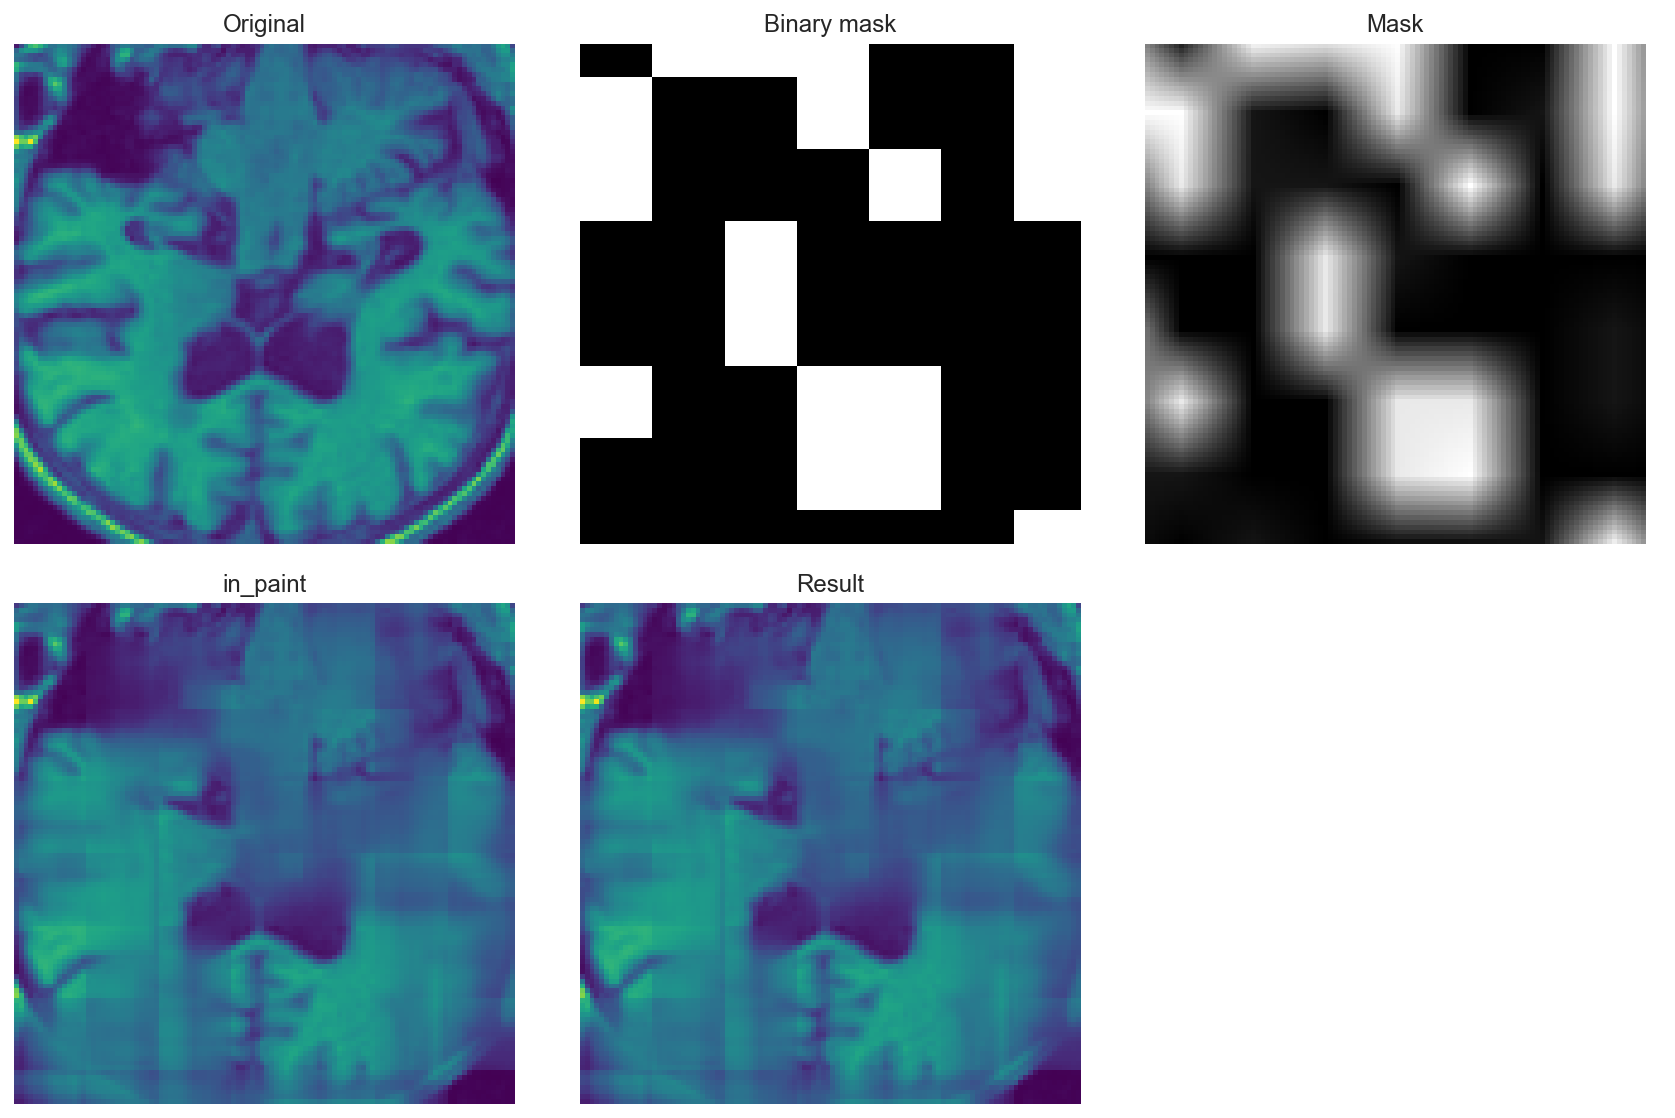

Wall time: 4.42 s


In [15]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=1, 
    b2=0, 
    in_paint='2d', 
    in_paint_blending=True, 
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

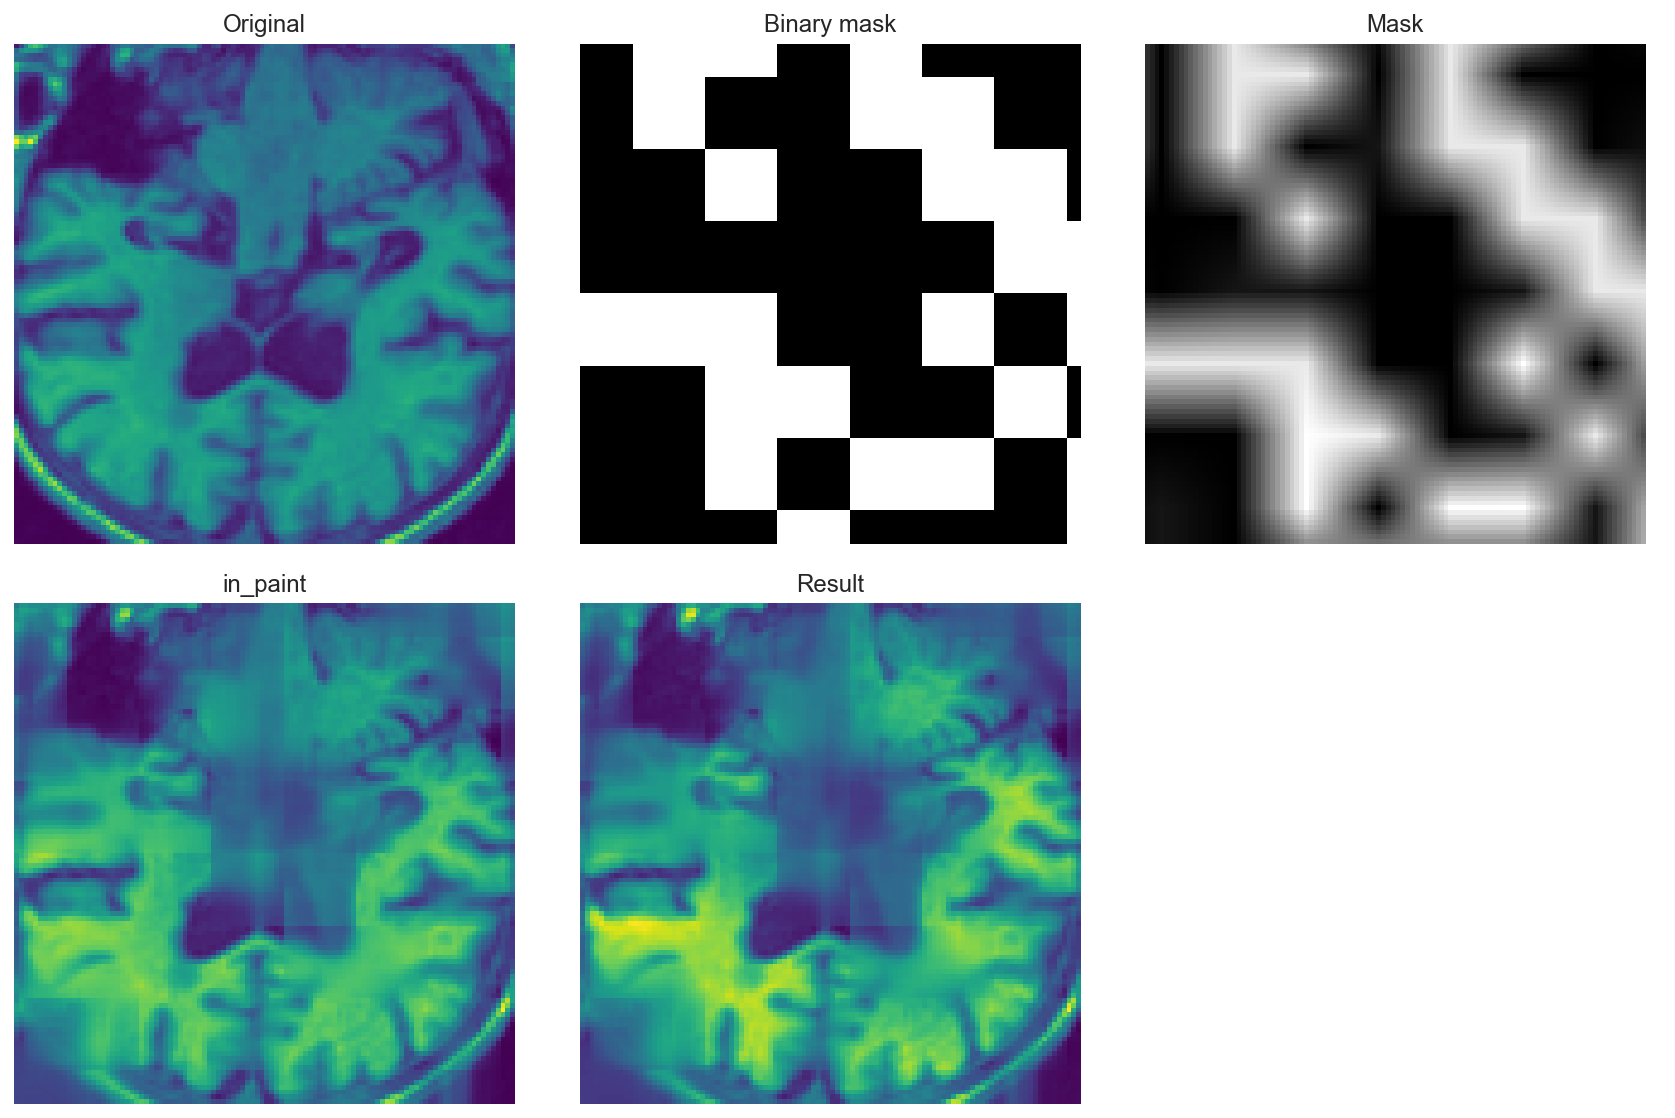

Wall time: 4.46 s


In [16]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=1, 
    b2=0.25, 
    in_paint='2d', 
    in_paint_blending=True, 
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

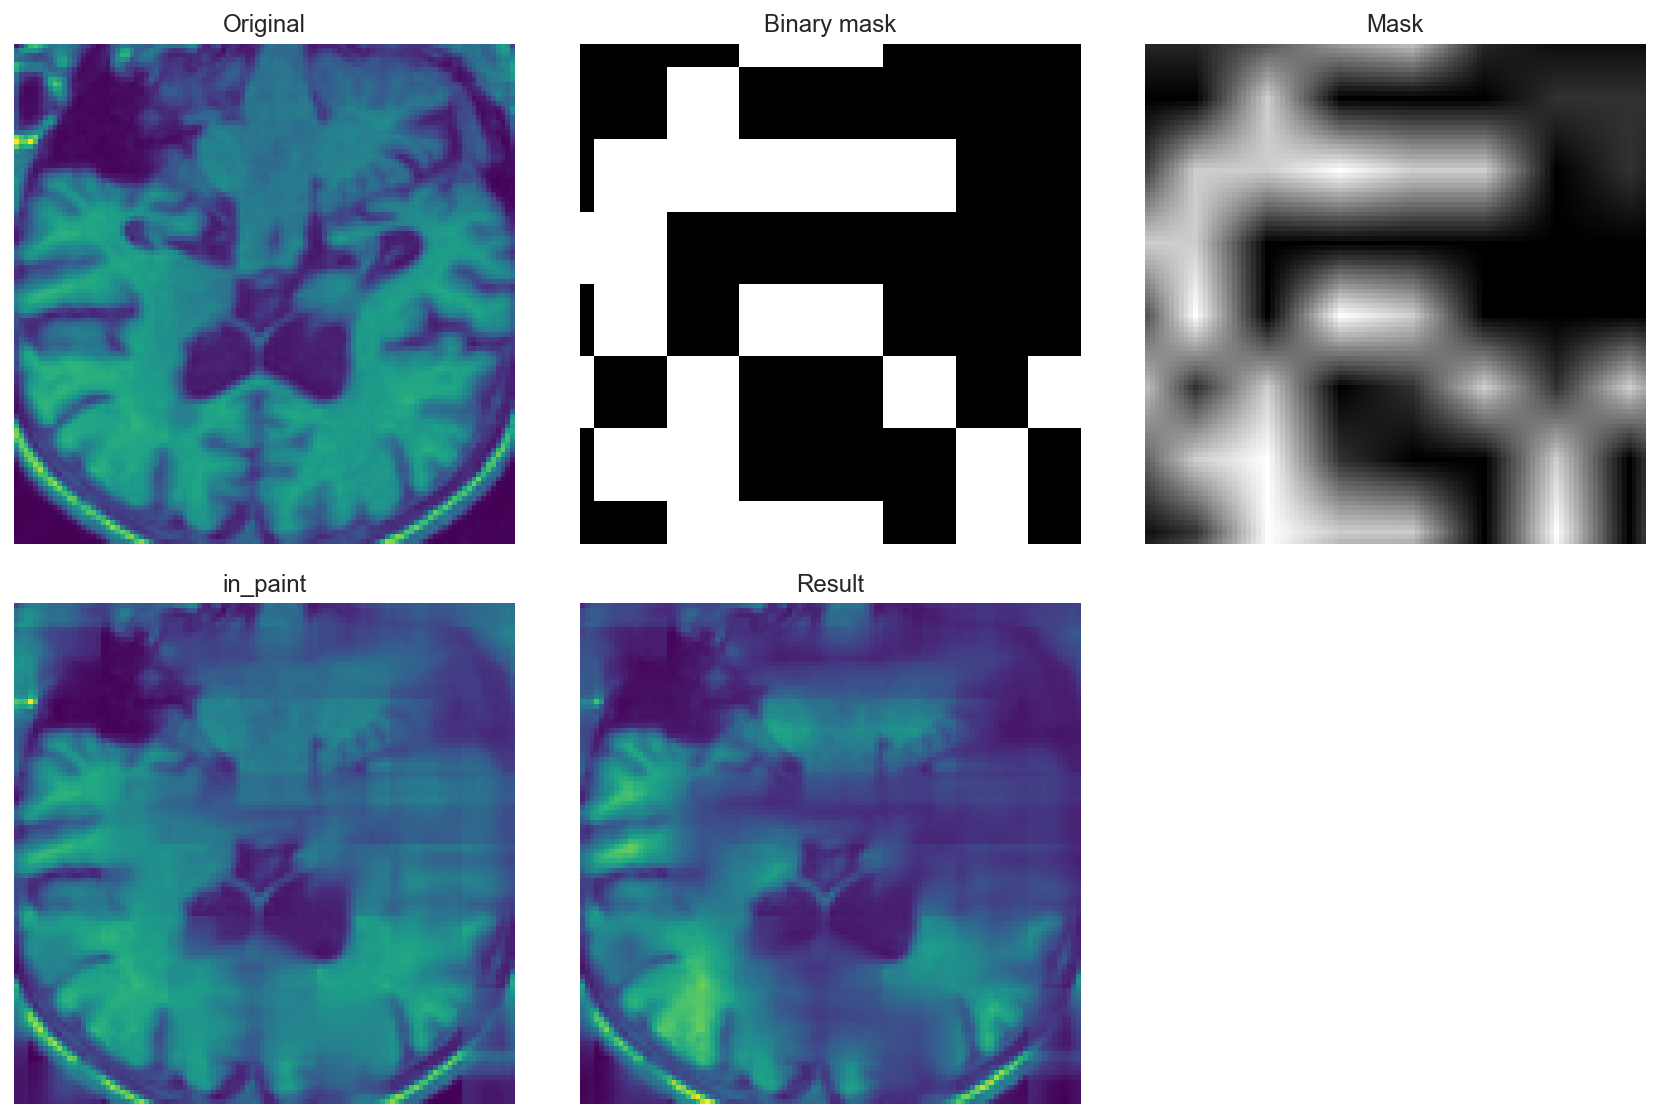

Wall time: 4.4 s


In [17]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=1, 
    b2=0.5, 
    in_paint='2d',
    in_paint_blending=True, 
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

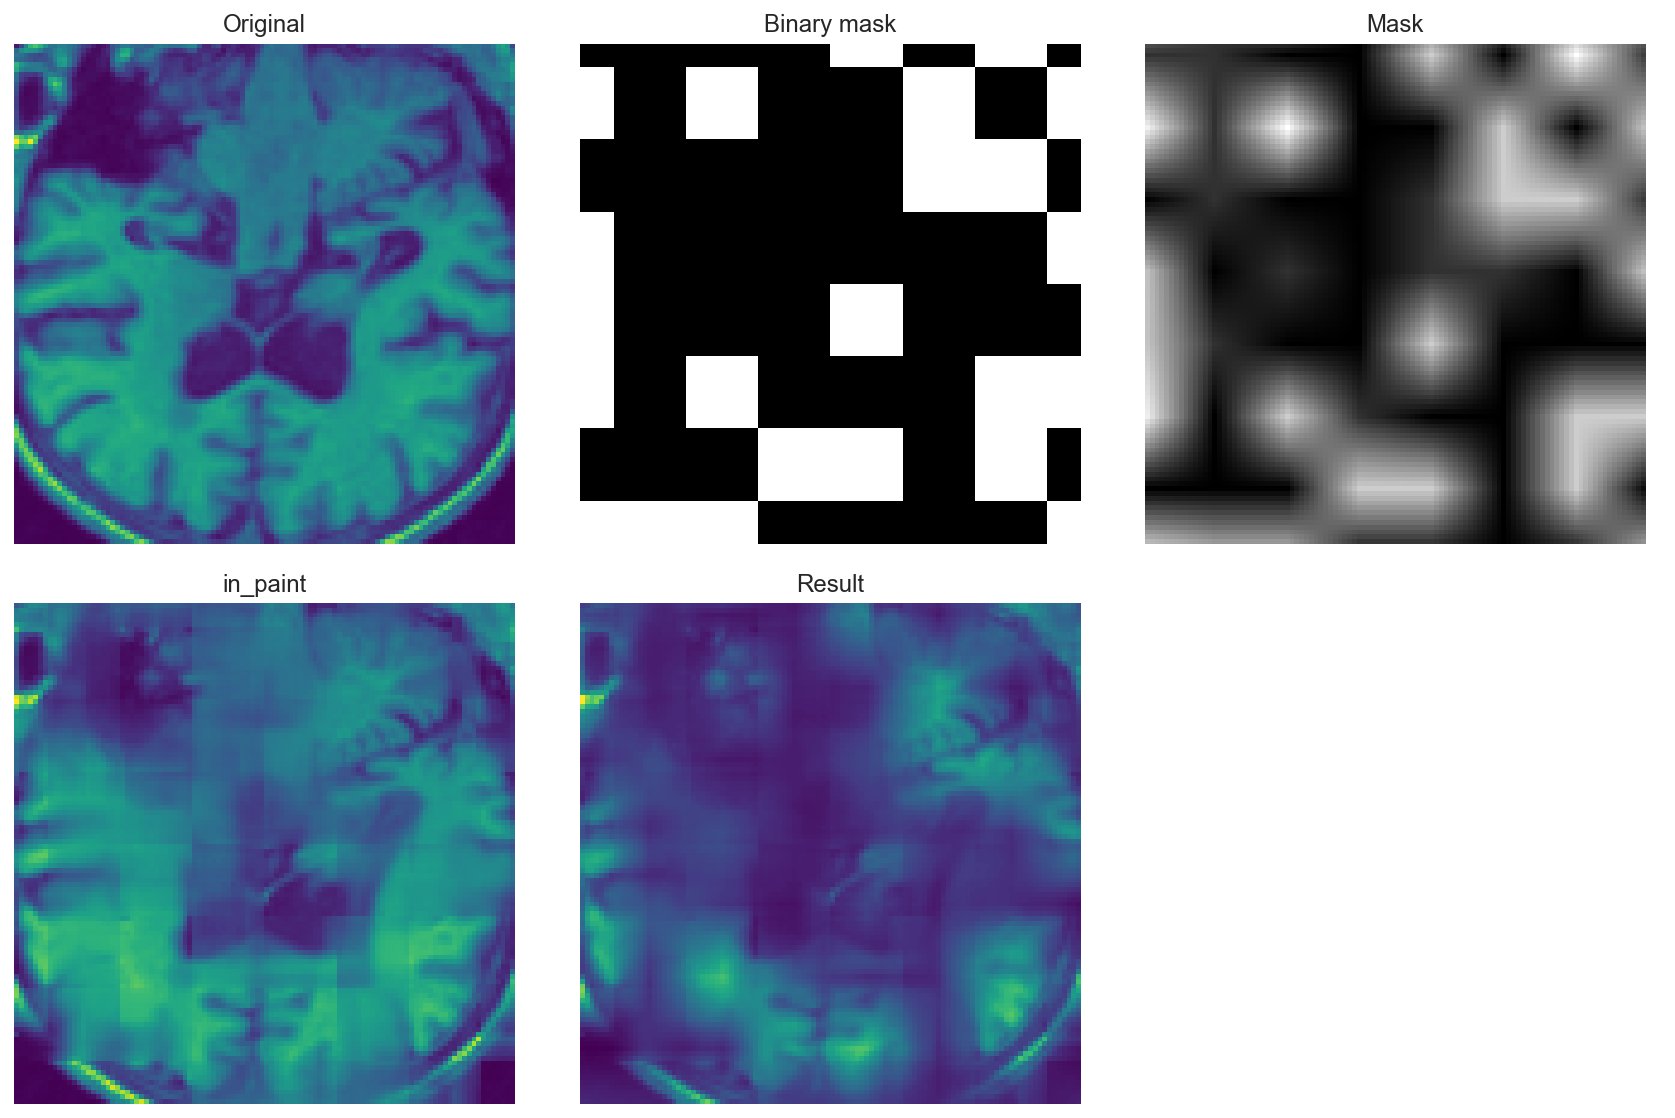

Wall time: 4.67 s


In [18]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=1, 
    b2=0.75,
    in_paint='2d', 
    in_paint_blending=True, 
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

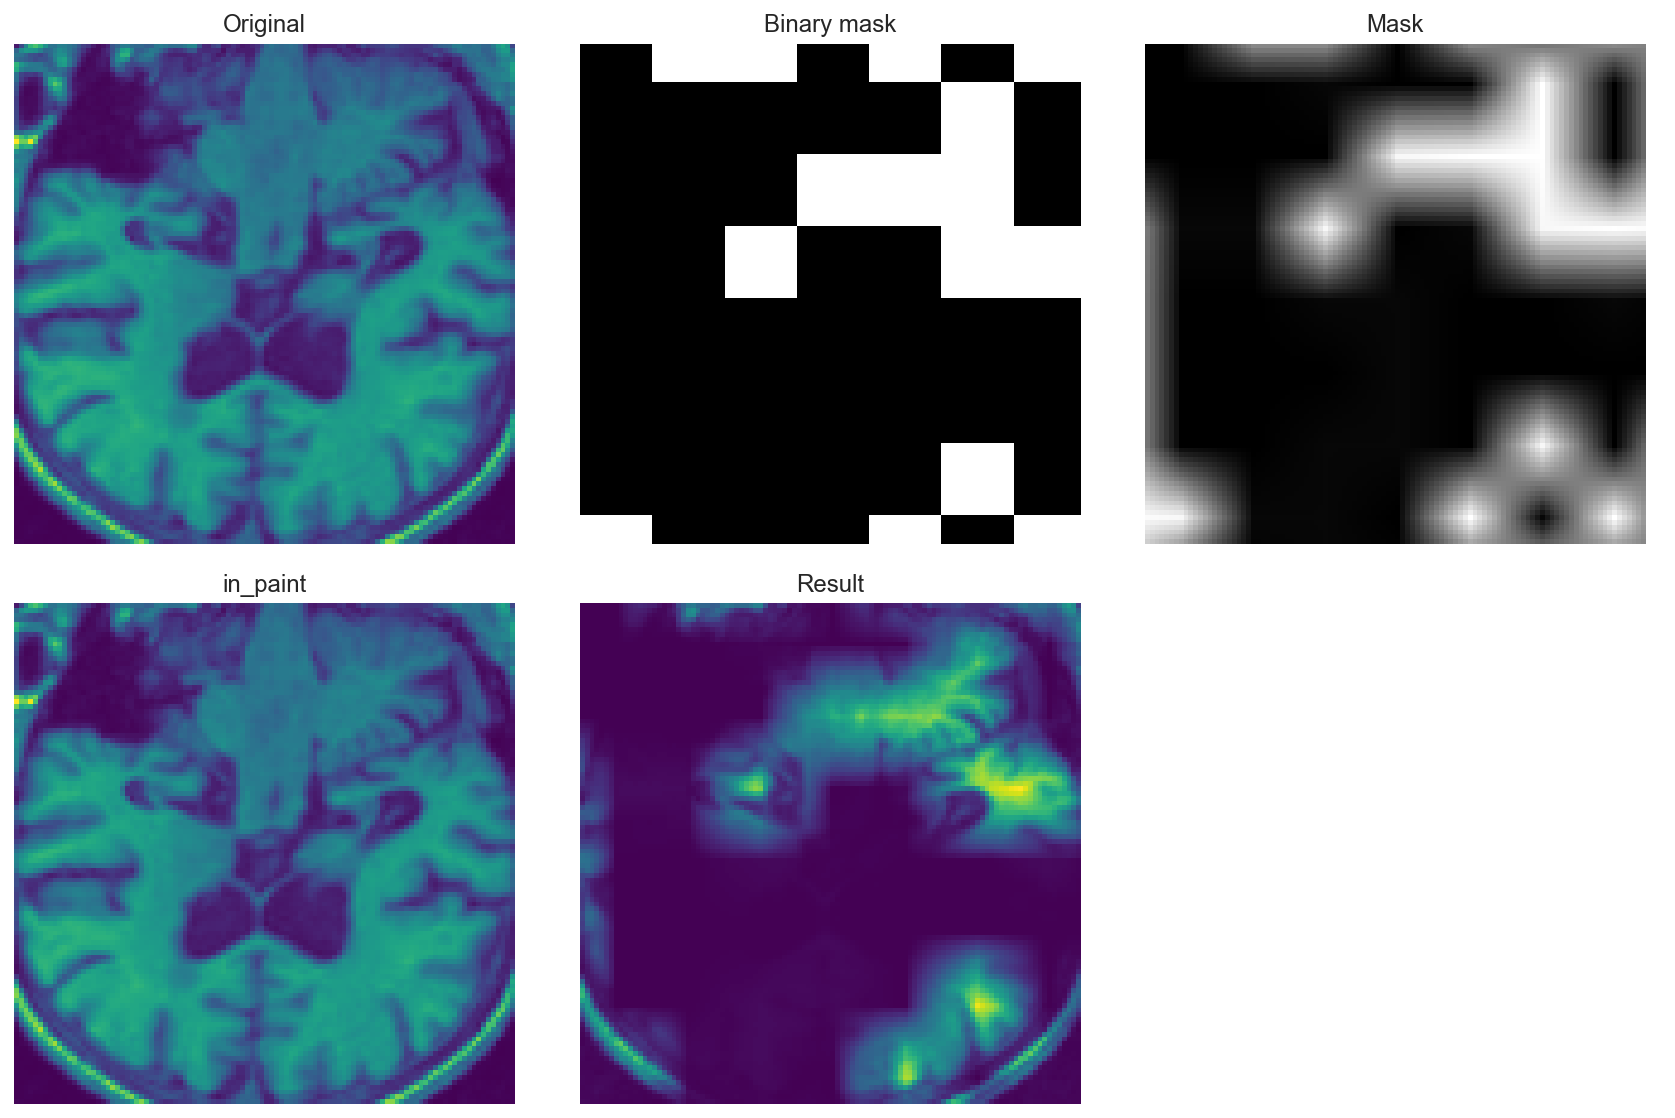

Wall time: 1 s


In [19]:
%%time

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=0, 
    b2=1, 
    in_paint='2d', 
    in_paint_blending=True, 
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=1, 
    debug=True)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), log=False)

risei.show_from_last_run(0, 56, dim=1)

### Generate

In [20]:
image_x = None
image_y = None

batch_x, batch_y, *_ = train_seq[0]
print(batch_y)

idx = 2
image_x = batch_x[idx]
image_y = batch_y[idx]

y_pred = model.predict(np.array([image_x]))

print(f'y_true: {np.argmax(image_y)}')
print(f'y_pred: {np.argmax(y_pred)}')
print(y_pred)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
y_true: 0
y_pred: 0
[[0.8578311  0.14216885]]


In [21]:
# Create a RISEI instance with a config.
# RISEI accepts shape without channels!
#
# p1 = probability of white place to be transparent
# b1 = inpaint mask blend (0 disables inpainting)
# b2 = black mask blend

processes = 8
debug = False

risei = RISEI(
    image_x.shape[:-1], 
    s=8, 
    p1=1/3, 
    b1=1,
    b2=0.5, 
    in_paint='2d', 
    in_paint_blending=True, 
    in_paint_radius=5,
    in_paint_2d_to_3d=True,
    processes=processes, 
    debug=debug)

In [22]:
%%time

# get a heatmap for a prediciton
heatmap, masks_x, masks_y = heatmaps.get_heatmap(
    image_x,
    image_y,
    model,
    risei,
    batch_size=train_config['batch_size'],
    masks_count=2400,
    risei_batch_size=480,
    debug=debug,
    log=True)

Generating masks: 100%|██████████| 480/480 [05:11<00:00,  1.54it/s]


Wall time: 27min 2s


In [23]:
if debug:
    heatmaps.show_mask(0, masks_x, masks_y, 56)

In [24]:
if debug:
    risei.show_from_last_run(0, 56)

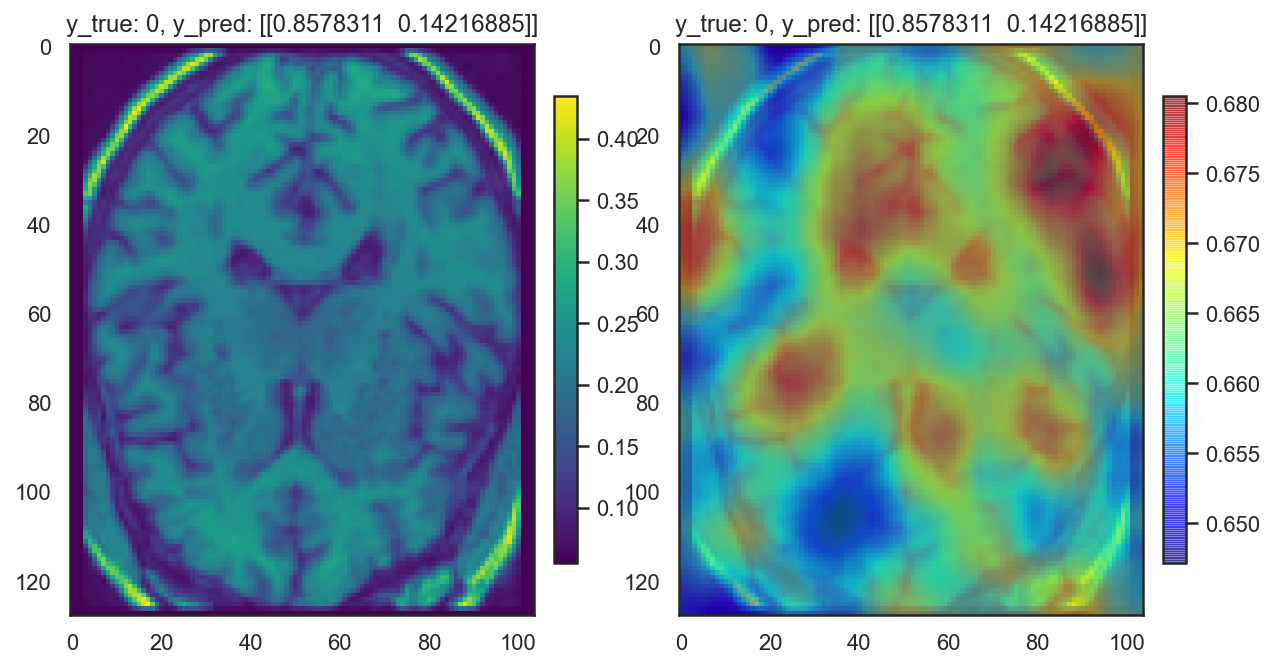

In [25]:
heatmaps.plot_heatmap_z(image_x, image_y, y_pred, heatmap, 56)

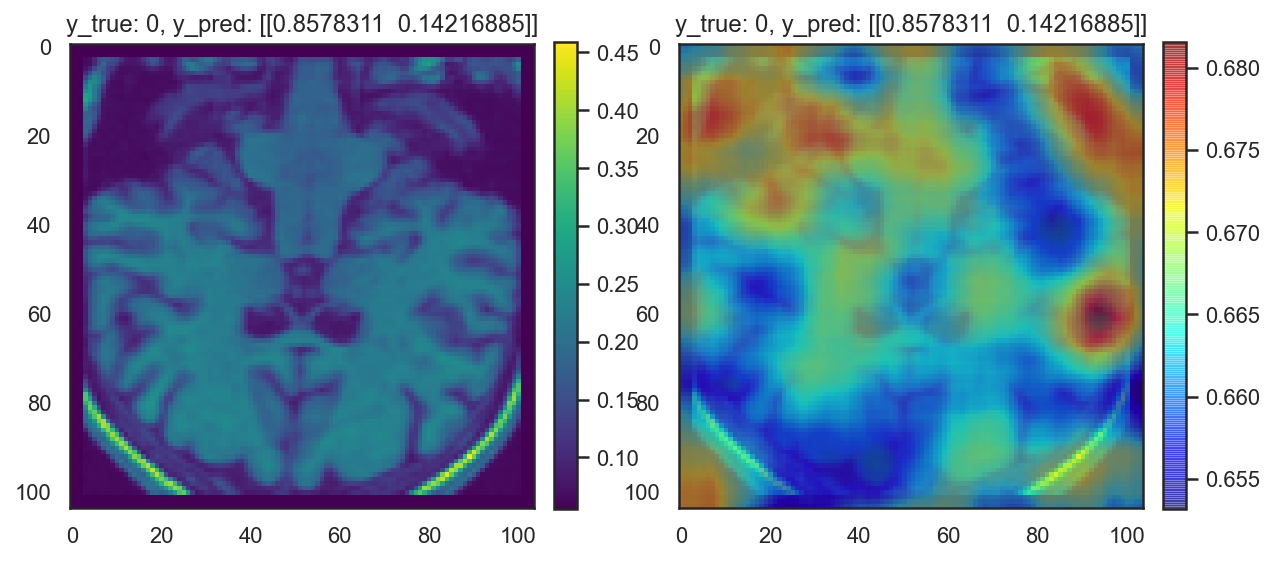

In [26]:
heatmaps.plot_heatmap_y(image_x, image_y, y_pred, heatmap, 56)

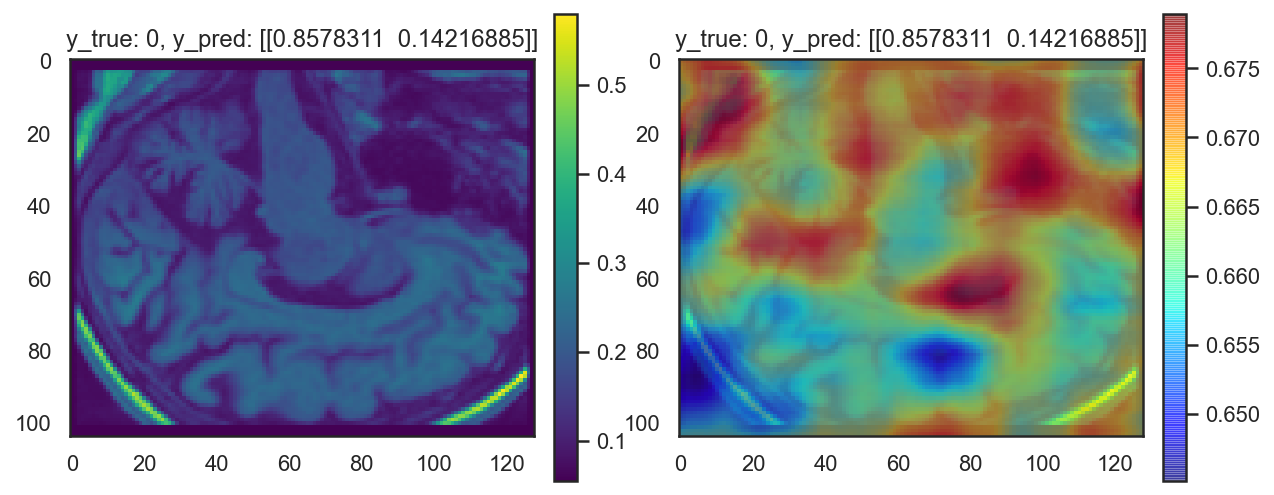

In [27]:
heatmaps.plot_heatmap_x(image_x, image_y, y_pred, heatmap, 56)

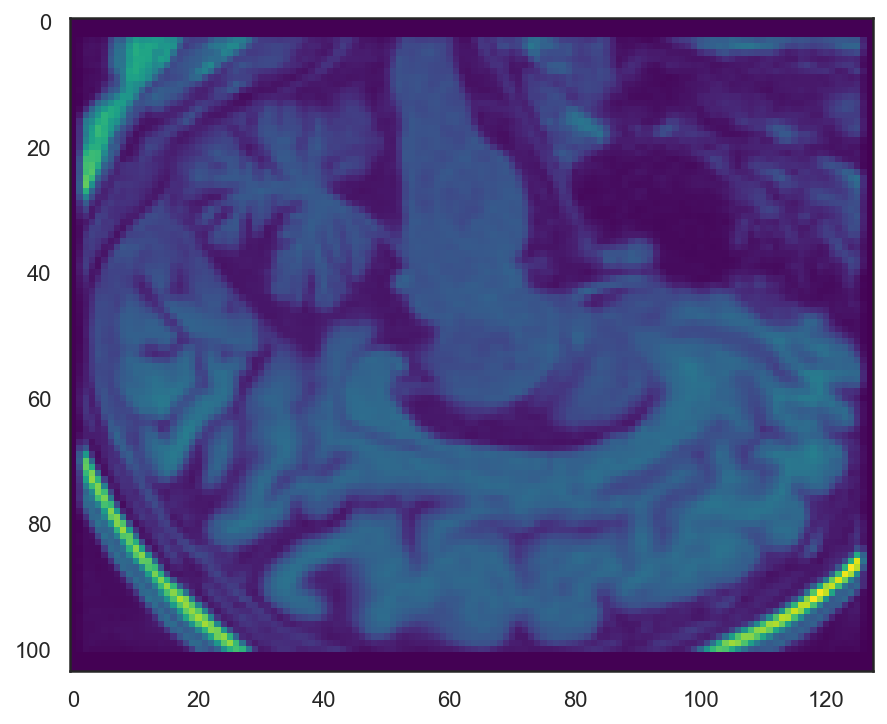

In [28]:
import matplotlib.pyplot as plt

img = image_x[:, :, 56, :]
plt.imshow(img.reshape(img.shape[:-1]))

In [29]:
heatmap.shape

(104, 128, 104)

### Evaluation

In [30]:
eval_seq_batch_size = batch_size * 4



eval_seq = EvaluationSequence(
    'insertion',
    image_x,
    heatmap,
    step_size=150,
    max_steps=1000 * 1000 * 10,
    batch_size=eval_seq_batch_size,
    debug=False,
    log=False
)

In [31]:
%%time

y_pred = predict_sequence_as_numpy(model, eval_seq, batch_size, log=False)

Wall time: 3min 25s


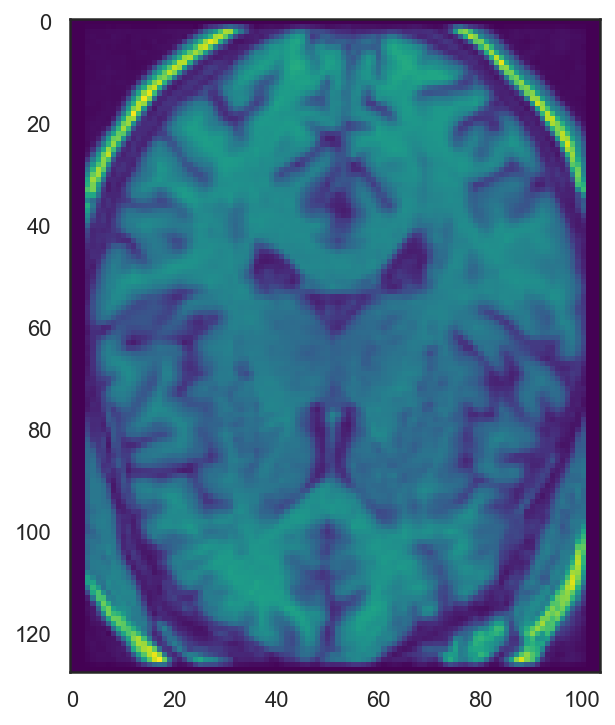

In [32]:
plot_image.plot_image_z(eval_seq.new_image, 56)

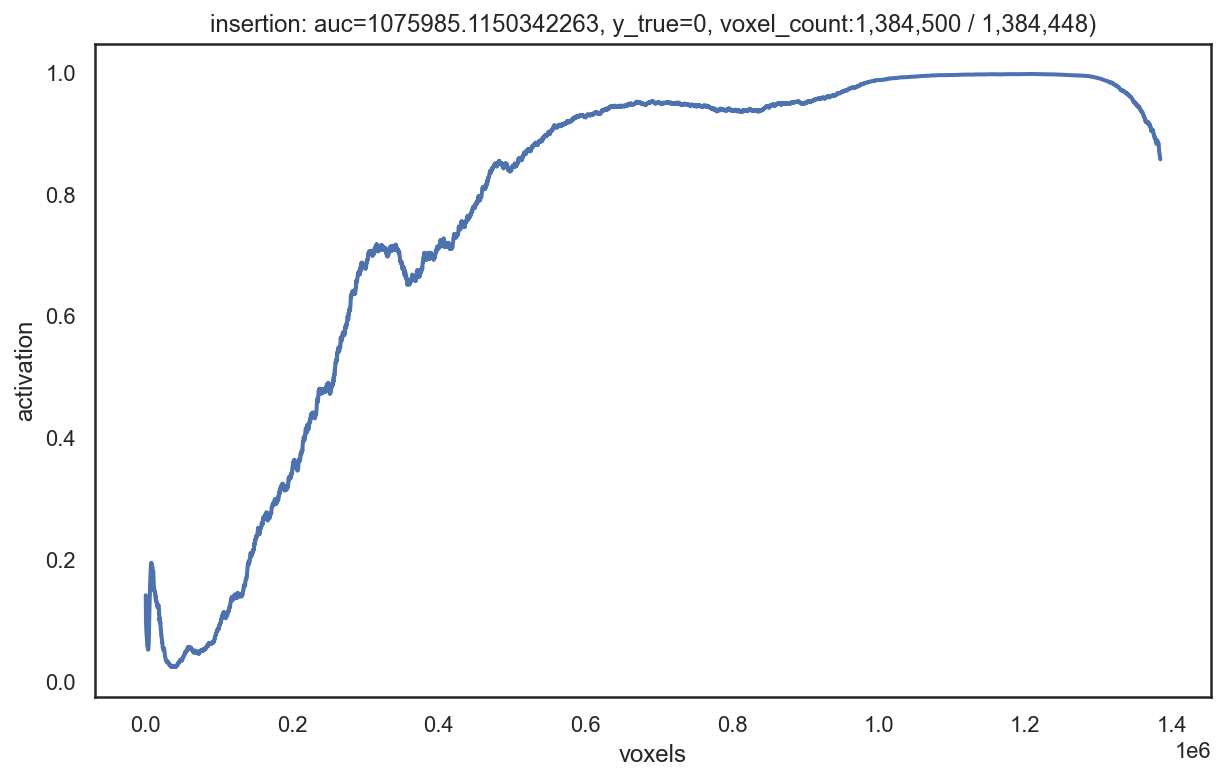

In [33]:
plot_evaluation(image_y, y_pred, eval_seq, title='insertion')